In [222]:
import pandas as pd
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer, pipeline
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import r2_score


tf.get_logger().setLevel('ERROR')

### Setup the dataset

In [205]:
df = pd.read_csv('data.csv')

In [206]:
# Drop useless columns
df.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'], axis=1, inplace=True)

In [207]:
# Drop rows with NaN values
df.dropna(inplace=True)

<Axes: xlabel='Score'>

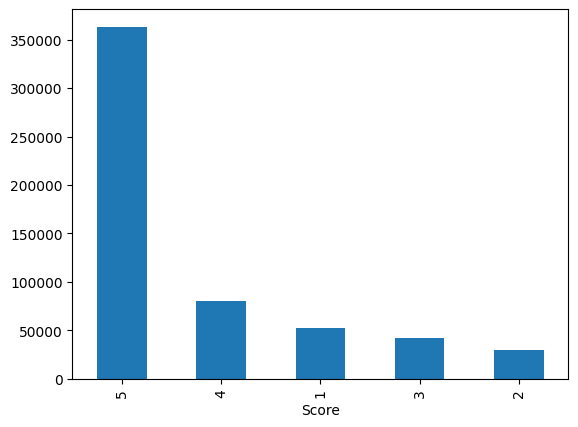

In [208]:
# Plot the distribution of the ratings
df['Score'].value_counts().plot(kind='bar')

<Axes: xlabel='Score'>

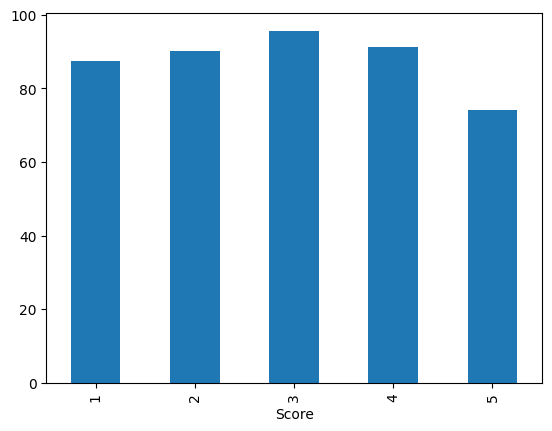

In [209]:
# Plot mean length of reviews per score

df['length'] = df['Text'].apply(lambda x: len(x.split()))
df.groupby('Score')['length'].mean().plot(kind='bar')

,Score,Summary,Text,length
1116,0.75,Worth it for me,"I've had this for a couple of weeks now, and I...",313
1368,1.00,Curry,I really like this product. It's very tasty an...,32
422,0.25,Blondie Mix,The delivery was on time and produce was well ...,44
413,0.25,Pirate Booty - Not GMO-free!,"In order to be truly a ""natural"" product, Pira...",31
451,0.25,Not that great,These Chewy Gooey Megafudge cookies are really...,102
861,0.50,Quado dog toy,"My two boys really loved these Quado chewies, ...",31
1063,0.75,Good Muffins,I'm new at this Glutten free diet so I ordered...,78
741,0.50,Moravian Cookies,THESE ARE ABSOLUTELY WONDERFUL COOKIES AND WE ...,44
1272,1.00,Almost instant gratification,"These minis are perfect for teen sleepovers, o...",15
259,0.00,Horrid new taste,"Watch out for the ""new and improved taste"" ins...",80


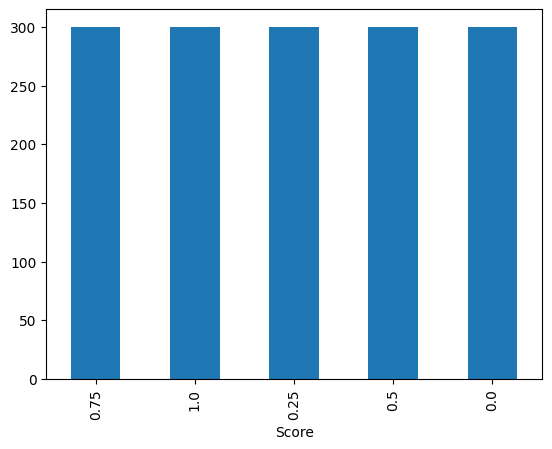

In [210]:
# Egalize the number of reviews per score and shuffle the dataframe

df = df.groupby('Score').apply(lambda x: x.sample(n=300, random_state=42)).reset_index(drop=True)

df = df.sample(frac=1, random_state=42)

df["Score"] = df["Score"].apply(lambda x: (x - 1)/4)


# Plot the distribution of the ratings

df['Score'].value_counts().plot(kind='bar')
df.head(20)


In [211]:
# Split the dataset into train, test sets

train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

X_train = train_df['Text'].values
y_train = train_df['Score'].values

X_test = test_df['Text'].values
y_test = test_df['Score'].values

### Process the dataset

In [212]:
# Build bert tf model

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(200, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(200, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(100, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

2023-06-14 23:36:59.663156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-14 23:36:59.663823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-14 23:36:59.663993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-14 23:36:59.664479: I tensorflow/core/

In [213]:
# Test the naive model

bert_raw_result = classifier_model(tf.constant(["this is a test"]))
print(bert_raw_result)

tf.Tensor([[0.34698483]], shape=(1, 1), dtype=float32)


In [214]:
# Compile the model

classifier_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='mae',
    metrics=['mae', 'mse']
)

In [215]:
# Train the model

history = classifier_model.fit(
    x=X_train,
    y=y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=5
)

Epoch 1/5


2023-06-14 23:37:08.721565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_3' with dtype float and shape [?,?,512]
	 [[{{node gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_3}}]]
2023-06-14 23:37:08.721685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_4' with dtype float and shape [?,?,512]
	 [[{{node gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPartitionedCall_4}}]]
2023

30/30 [==============================] - 172s 5s/step - loss: 0.3061 - mae: 0.3061 - mse: 0.1254 - val_loss: 0.3060 - val_mae: 0.3060 - val_mse: 0.1264
Epoch 2/5
30/30 [==============================] - 166s 6s/step - loss: 0.2972 - mae: 0.2972 - mse: 0.1193 - val_loss: 0.2958 - val_mae: 0.2958 - val_mse: 0.1183
Epoch 3/5
30/30 [==============================] - 144s 5s/step - loss: 0.2882 - mae: 0.2882 - mse: 0.1132 - val_loss: 0.2836 - val_mae: 0.2836 - val_mse: 0.1079
Epoch 4/5
30/30 [==============================] - 114s 4s/step - loss: 0.2776 - mae: 0.2776 - mse: 0.1064 - val_loss: 0.2651 - val_mae: 0.2651 - val_mse: 0.0955
Epoch 5/5
30/30 [==============================] - 112s 4s/step - loss: 0.2625 - mae: 0.2625 - mse: 0.0975 - val_loss: 0.2520 - val_mae: 0.2520 - val_mse: 0.0889


In [223]:
# Evaluate the model with r2 score

loss, mae, mse = classifier_model.evaluate(X_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Score".format(mae))
print("Testing set Mean Squared Error: {:5.2f} Score".format(mse))
print("Testing set R2 Score: {:5.2f} Score".format(r2_score(y_test, classifier_model.predict(X_test))))



10/10 - 8s - loss: 0.2719 - mae: 0.2719 - mse: 0.1022 - 8s/epoch - 815ms/step
Testing set Mean Abs Error:  0.27 Score
Testing set Mean Squared Error:  0.10 Score
10/10 [==============================] - 8s 800ms/step
Testing set R2 Score:  0.25 Score


10/10 [==============================] - 8s 821ms/step


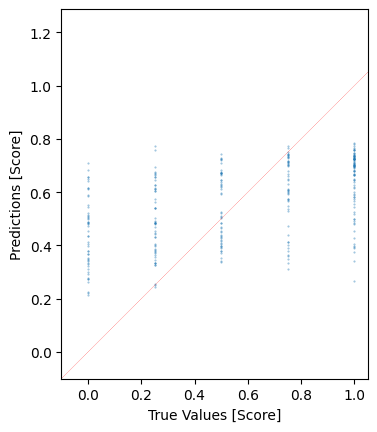

In [228]:
# Plot predictions vs real values

import matplotlib.pyplot as plt

y_pred = classifier_model.predict(X_test)

plt.scatter(y_test, y_pred, s=0.2, alpha=0.5)
plt.xlabel('True Values [Score]')
plt.ylabel('Predictions [Score]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-0.1,plt.xlim()[1]])
plt.ylim([-0.1,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100], color='red', linestyle='--', linewidth=0.2)


In [231]:
# Test the model

good_review = "Very Good"
bad_review = "very Bad"

print(good_review)
print(bad_review)


classifier_model.predict([good_review, bad_review])

Very Good
very Bad
1/1 [==============================] - 0s 114ms/step


array([[0.610948  ],
       [0.44985402]], dtype=float32)